In [1]:
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
np.random.seed(42)

In [3]:
DATA_DIR = join('..', 'data', 'raw')

In [4]:
train_df = pd.read_csv(join(DATA_DIR, 'train.csv'))
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
train_df.shape

(404290, 6)

In [6]:
test_df = pd.read_csv(join(DATA_DIR, 'test.csv'))
test_df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [7]:
test_df.shape

(2345796, 3)

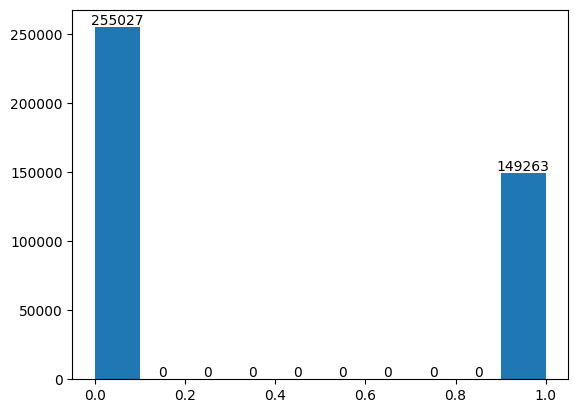

In [8]:
_, _, bars = plt.hist(train_df.is_duplicate)
plt.bar_label(bars)
plt.show()

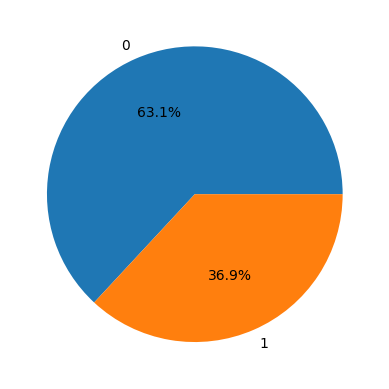

In [9]:
plt.pie(
    train_df.is_duplicate.value_counts(), 
    labels=train_df.is_duplicate.value_counts().index, 
    autopct='%1.1f%%'
)
plt.show()

In [10]:
non_asciis, non_strs = [], []

for i, row in train_df.iterrows():
    for question in [row['question1'], row['question2']]:
        if type(question) != str:
            non_strs.append(row)
        elif not question.isascii():
            non_asciis.append(row)

len(non_strs), len(non_asciis)

(3, 9612)

In [11]:
non_strs

[id                                      105780
 qid1                                    174363
 qid2                                    174364
 question1       How can I develop android app?
 question2                                  NaN
 is_duplicate                                 0
 Name: 105780, dtype: object,
 id                                        201841
 qid1                                      303951
 qid2                                      174364
 question1       How can I create an Android app?
 question2                                    NaN
 is_duplicate                                   0
 Name: 201841, dtype: object,
 id                                                         363362
 qid1                                                       493340
 qid2                                                       493341
 question1                                                     NaN
 question2       My Chinese name is Haichao Yu. What English na...
 is_duplicate    

In [12]:
non_asciis[0]

id                                                  8
qid1                                               17
qid2                                               18
question1             When do you use シ instead of し?
question2       When do you use "&" instead of "and"?
is_duplicate                                        0
Name: 8, dtype: object

In [13]:
train_df = train_df.fillna("") # replace NaN with empty string

In [14]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nguyenvanbinh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
word_tokenize('How can I create an Android app?'.lower())

['how', 'can', 'i', 'create', 'an', 'android', 'app', '?']

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from nltk.tokenize import word_tokenize

torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X = train_df[['question1', 'question2']]
X.loc['tokenized_q1'] = X['question1'].apply(lambda x: word_tokenize(x.lower()))
X.loc['tokenized_q2'] = X['question2'].apply(lambda x: word_tokenize(x.lower()))
X = X[['tokenized_q1', 'tokenized_q2']].reset_index(drop=True)

y = train_df['is_duplicate']
y = torch.tensor(y, dtype=torch.float32)

X.head()

/var/folders/l3/2pgq90f125lbwlmh0s3lrt4m0000gp/T/ipykernel_13379/1806934722.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['tokenized_q1'] = X['question1'].apply(lambda x: word_tokenize(x.lower()))
/var/folders/l3/2pgq90f125lbwlmh0s3lrt4m0000gp/T/ipykernel_13379/1806934722.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['tokenized_q2'] = X['question2'].apply(lambda x: word_tokenize(x.lower()))


,tokenized_q1,tokenized_q2
0,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv..."
1,"[what, is, the, story, of, kohinoor, (, koh-i-...","[what, would, happen, if, the, indian, governm..."
2,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,..."
3,"[why, am, i, mentally, very, lonely, ?, how, c...","[find, the, remainder, when, [, math, ], 23^, ..."
4,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water, ?]"


In [19]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [20]:
X_train.head()

,tokenized_q1,tokenized_q2
230032,"[is, scam, audit.com, a, legit, website, ?]","[is, asos.com, a, legit, website, or, a, scam, ?]"
248995,"[why, does, india, abuse, bangladesh, ?, why, ...","[why, do, china, ,, india, ,, bangladesh, ,, a..."
150546,"[why, ms, dhoni, left, captaincy, though, he, ...","[why, ms, dhoni, has, quit, the, captaincy, fr..."
45388,"[i, compose, songs, ,, can, the, songs, help, ...","[i, am, trying, very, hard, to, recollect, a, ..."
264347,"[what, do, finance, people, think, of, zerohed...","[how, do, i, learn, quantitative, finance, ?]"


In [21]:
X_train.shape

(258745, 2)

In [22]:
y_train, y_train.shape

(tensor([0., 0., 1.,  ..., 0., 1., 1.]), torch.Size([258745]))

In [23]:
word_count = {}

for col in ['tokenized_q1', 'tokenized_q2']:
    for lst in X_train[col]:
        for word in lst:
            word_count[word] = word_count.get(word, 0) + 1

In [24]:
len(word_count)

90332

In [25]:
sorted_word_counts = sorted(word_count.items(), key=lambda x: x[1], reverse=True)

In [26]:
sorted_word_counts[:10]

[('?', 545627),
 ('the', 241958),
 ('what', 207918),
 ('is', 173478),
 ('i', 141763),
 ('how', 140954),
 ('a', 134848),
 ('to', 131524),
 ('in', 126177),
 ('do', 107755)]

In [27]:
for i, (_, count) in enumerate(sorted_word_counts):
    if count == 1:
        print(f"Number of words occurring more than once: {i}")
        break

Number of words occurring more than once: 48122


In [28]:
vocab = set(word_count.keys())
vocab.add('<>SEP</>') # separator between 2 sentences
vocab.add('<>UKN</>')

word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for idx, word in enumerate(vocab)}

In [56]:
class RNNModel(nn.Module):
    
    def __init__(
        self, vocab_size, embedding_dim, hidden_dim, num_rnn_layers=1,
        num_linear_layers=1, dropout=0, rnn_type='rnn'
    ):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        if rnn_type == 'rnn':
            self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_lstm_layers, batch_first=True, dropout=dropout)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_lstm_layers, batch_first=True, dropout=dropout)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_lstm_layers, batch_first=True, dropout=dropout)
        
        self.fcs = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_linear_layers-1)] 
            + [nn.Linear(hidden_dim, 1)]
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = x.mean(dim=1) 
        for fc in self.fcs[:-1]:
            x = F.relu(fc(x))
        x = self.fcs[-1](x)
        out = self.sigmoid(x)
        return out
        

class DuplicateQuestionDataset(Dataset):
    
    def __init__(self, questions, labels, word_to_idx):
        self.questions = questions
        self.labels = labels
        self.word_to_idx = word_to_idx

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        q1, q2 = self.questions.iloc[idx]
        word_indices = [self.word_to_idx.get(word, self.word_to_idx['<>UKN</>']) for word in q1]
        word_indices.append(self.word_to_idx['<>SEP</>'])
        word_indices.extend([self.word_to_idx.get(word, self.word_to_idx['<>UKN</>']) for word in q1])
        return torch.tensor(word_indices).to(device), self.labels[idx].to(device)

In [58]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn_pad(batch):
    questions, labels = zip(*batch)
    padded_questions = pad_sequence(questions, batch_first=True, padding_value=0)
    return padded_questions, torch.stack(labels)

batch_size = 64

train_dataset = DuplicateQuestionDataset(X_train, y_train, word_to_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_pad)

val_dataset = DuplicateQuestionDataset(X_val, y_val, word_to_idx)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_pad)

test_dataset = DuplicateQuestionDataset(X_val, y_val, word_to_idx)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_pad)

In [ ]:
config = {
    'embedding_dim': 16,
    'hidden_dim': 16,
    'num_rnn_layers': 2
    'num_linear_layers': 4,
    'dropout': 0,
    'rnn_type': 'rnn',
}

In [ ]:
vocab_size = len(vocab)

model = RNNModel(
    vocab_size, config['embedding_dim'], config['hidden_dim'], config['num_rnn_layers'], 
    config['num_linear_layers'], config['dropout'], config['rnn_type']
).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

In [59]:
num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0
    for (questions, labels) in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = model(questions)
        loss = criterion(outputs.view(-1), labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Epoch {epoch+1}: loss = {total_loss:.2f}")

Epoch 1/10:   0%|          | 0/4043 [00:00<?, ?it/s]

Epoch 1: loss = 2215.07


Epoch 2/10:   0%|          | 0/4043 [00:00<?, ?it/s]

Epoch 2: loss = 1967.22


Epoch 3/10:   0%|          | 0/4043 [00:00<?, ?it/s]

Epoch 3: loss = 1834.88


Epoch 4/10:   0%|          | 0/4043 [00:00<?, ?it/s]

Epoch 4: loss = 1740.82


Epoch 5/10:   0%|          | 0/4043 [00:00<?, ?it/s]

Epoch 5: loss = 1674.17


Epoch 6/10:   0%|          | 0/4043 [00:00<?, ?it/s]

Epoch 6: loss = 1622.62


Epoch 7/10:   0%|          | 0/4043 [00:00<?, ?it/s]

Epoch 7: loss = 1583.79


Epoch 8/10:   0%|          | 0/4043 [00:00<?, ?it/s]

Epoch 8: loss = 1560.99


Epoch 9/10:   0%|          | 0/4043 [00:00<?, ?it/s]

Epoch 9: loss = 1538.35


Epoch 10/10:   0%|          | 0/4043 [00:00<?, ?it/s]

Epoch 10: loss = 1525.76


In [60]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for questions, labels in tqdm(train_loader):
        outputs = model(questions)
        predicted = (outputs > 0.5).float().view(-1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Train Accuracy: {accuracy:.2f}%")

  0%|          | 0/4043 [00:00<?, ?it/s]

Train Accuracy: 83.24%


In [61]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for questions, labels in tqdm(val_loader):
        outputs = model(questions)
        predicted = (outputs > 0.5).float().view(-1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")

  0%|          | 0/1011 [00:00<?, ?it/s]

Validation Accuracy: 73.81%
